# Sudoku Solver and OCR

### Install the necessary packages

In [ ]:
!pip install tensorflow==2.2.0
!pip install py-sudoku

In [2]:
%cd opencv-sudoku-solver

/content/opencv-sudoku-solver


### Import Packages

In [3]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
from matplotlib import pyplot as plt
from sudoku import Sudoku
import numpy as np
import argparse
import imutils
import cv2

Function to display images in Jupyter Notebooks and Google Colab

In [4]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### SudokuNet: A digit OCR model implemented in Keras and TensorFlow

In [5]:
class SudokuNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model
		model = Sequential()
		inputShape = (height, width, depth)

		# first set of CONV => RELU => POOL layers
		model.add(Conv2D(32, (5, 5), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# second set of CONV => RELU => POOL layers
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# first set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(64))
		model.add(Activation("relu"))
		model.add(Dropout(0.5))

		# second set of FC => RELU layers
		model.add(Dense(64))
		model.add(Activation("relu"))
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

### Implementing our Sudoku digit training script with Keras and TensorFlow

In [6]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"model": "output/digit_classifier.h5"
}

In [7]:
# initialize the initial learning rate, number of epochs to train
# for, and batch size
INIT_LR = 1e-3
EPOCHS = 10
BS = 128

# grab the MNIST dataset
print("[INFO] accessing MNIST...")
((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()

# add a channel (i.e., grayscale) dimension to the digits
trainData = trainData.reshape((trainData.shape[0], 28, 28, 1))
testData = testData.reshape((testData.shape[0], 28, 28, 1))

# scale data to the range of [0, 1]
trainData = trainData.astype("float32") / 255.0
testData = testData.astype("float32") / 255.0

# convert the labels from integers to vectors
le = LabelBinarizer()
trainLabels = le.fit_transform(trainLabels)
testLabels = le.transform(testLabels)

[INFO] accessing MNIST...


In [8]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR)
model = SudokuNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(
	trainData, trainLabels,
	validation_data=(testData, testLabels),
	batch_size=BS,
	epochs=EPOCHS,
	verbose=1)

[INFO] compiling model...
[INFO] training network...
Epoch 1/10
469/469 [==============================] - 2s 5ms/step - loss: 0.6855 - accuracy: 0.7735 - val_loss: 0.0926 - val_accuracy: 0.9717
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.2509 - accuracy: 0.9260 - val_loss: 0.0638 - val_accuracy: 0.9802
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1852 - accuracy: 0.9459 - val_loss: 0.0470 - val_accuracy: 0.9849
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1526 - accuracy: 0.9560 - val_loss: 0.0418 - val_accuracy: 0.9871
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1347 - accuracy: 0.9604 - val_loss: 0.0464 - val_accuracy: 0.9854
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1210 - accuracy: 0.9648 - val_loss: 0.0358 - val_accuracy: 0.9886
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1140 - accuracy: 0.

In [9]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testData)
print(classification_report(
	testLabels.argmax(axis=1),
	predictions.argmax(axis=1),
	target_names=[str(x) for x in le.classes_]))

# serialize the model to disk
print("[INFO] serializing digit model...")
model.save(args["model"], save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

[INFO] serializing digit model...


### Finding the Sudoku puzzle board in an image with OpenCV

In [10]:
def find_puzzle(image, debug=False):
	# convert the image to grayscale and blur it slightly
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	blurred = cv2.GaussianBlur(gray, (7, 7), 3)

	# apply adaptive thresholding and then invert the threshold map
	thresh = cv2.adaptiveThreshold(blurred, 255,
		cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
	thresh = cv2.bitwise_not(thresh)

	# check to see if we are visualizing each step of the image
	# processing pipeline (in this case, thresholding)
	if debug:
		plt_imshow("Puzzle Thresh", thresh)

	# find contours in the thresholded image and sort them by size in
	# descending order
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

	# initialize a contour that corresponds to the puzzle outline
	puzzleCnt = None

	# loop over the contours
	for c in cnts:
		# approximate the contour
		peri = cv2.arcLength(c, True)
		approx = cv2.approxPolyDP(c, 0.02 * peri, True)

		# if our approximated contour has four points, then we can
		# assume we have found the outline of the puzzle
		if len(approx) == 4:
			puzzleCnt = approx
			break

	# if the puzzle contour is empty then our script could not find
	# the outline of the sudoku puzzle so raise an error
	if puzzleCnt is None:
		raise Exception(("Could not find sudoku puzzle outline. "
			"Try debugging your thresholding and contour steps."))

	# check to see if we are visualizing the outline of the detected
	# sudoku puzzle
	if debug:
		# draw the contour of the puzzle on the image and then display
		# it to our screen for visualization/debugging purposes
		output = image.copy()
		cv2.drawContours(output, [puzzleCnt], -1, (0, 255, 0), 2)
		plt_imshow("Puzzle Outline", output)

	# apply a four point perspective transform to both the original
	# image and grayscale image to obtain a top-down birds eye view
	# of the puzzle
	puzzle = four_point_transform(image, puzzleCnt.reshape(4, 2))
	warped = four_point_transform(gray, puzzleCnt.reshape(4, 2))

	# check to see if we are visualizing the perspective transform
	if debug:
		# show the output warped image (again, for debugging purposes)
		plt_imshow("Puzzle Transform", puzzle)

	# return a 2-tuple of puzzle in both RGB and grayscale
	return (puzzle, warped)

### Extracting digits from a Sudoku puzzle with OpenCV

In [11]:
def extract_digit(cell, debug=False):
	# apply automatic thresholding to the cell and then clear any
	# connected borders that touch the border of the cell
	thresh = cv2.threshold(cell, 0, 255,
		cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
	thresh = clear_border(thresh)

	# check to see if we are visualizing the cell thresholding step
	if debug:
		plt_imshow("Cell Thresh", thresh)

	# find contours in the thresholded cell
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)

	# if no contours were found than this is an empty cell
	if len(cnts) == 0:
		return None

	# otherwise, find the largest contour in the cell and create a
	# mask for the contour
	c = max(cnts, key=cv2.contourArea)
	mask = np.zeros(thresh.shape, dtype="uint8")
	cv2.drawContours(mask, [c], -1, 255, -1)

	# compute the percentage of masked pixels relative to the total
	# area of the image
	(h, w) = thresh.shape
	percentFilled = cv2.countNonZero(mask) / float(w * h)

	# if less than 3% of the mask is filled then we are looking at
	# noise and can safely ignore the contour
	if percentFilled < 0.03:
		return None

	# apply the mask to the thresholded cell
	digit = cv2.bitwise_and(thresh, thresh, mask=mask)

	# check to see if we should visualize the masking step
	if debug:
		plt_imshow("Digit", digit)

	# return the digit to the calling function
	return digit

### Implementing our OpenCV Sudoku puzzle solver

In [12]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"model": "output/digit_classifier.h5",
    "image": "sudoku_puzzle.jpg",
    "debug": -1
}

In [13]:
# load the digit classifier from disk
print("[INFO] loading digit classifier...")
model = load_model(args["model"])

# load the input image from disk and resize it
print("[INFO] processing image...")
image = cv2.imread(args["image"])
image = imutils.resize(image, width=600)

[INFO] loading digit classifier...
[INFO] processing image...


In [14]:
# find the puzzle in the image and then
(puzzleImage, warped) = find_puzzle(image, debug=args["debug"] > 0)

# initialize our 9x9 Sudoku board
board = np.zeros((9, 9), dtype="int")

# a Sudoku puzzle is a 9x9 grid (81 individual cells), so we can
# infer the location of each cell by dividing the warped image
# into a 9x9 grid
stepX = warped.shape[1] // 9
stepY = warped.shape[0] // 9

# initialize a list to store the (x, y)-coordinates of each cell
# location
cellLocs = []

In [15]:
# loop over the grid locations
for y in range(0, 9):
	# initialize the current list of cell locations
	row = []

	for x in range(0, 9):
		# compute the starting and ending (x, y)-coordinates of the
		# current cell
		startX = x * stepX
		startY = y * stepY
		endX = (x + 1) * stepX
		endY = (y + 1) * stepY

		# add the (x, y)-coordinates to our cell locations list
		row.append((startX, startY, endX, endY))

        # crop the cell from the warped transform image and then
		# extract the digit from the cell
		cell = warped[startY:endY, startX:endX]
		digit = extract_digit(cell, debug=args["debug"] > 0)

		# verify that the digit is not empty
		if digit is not None:
			# resize the cell to 28x28 pixels and then prepare the
			# cell for classification
			roi = cv2.resize(digit, (28, 28))
			roi = roi.astype("float") / 255.0
			roi = img_to_array(roi)
			roi = np.expand_dims(roi, axis=0)

			# classify the digit and update the Sudoku board with the
			# prediction
			pred = model.predict(roi).argmax(axis=1)[0]
			board[y, x] = pred

	# add the row to our cell locations
	cellLocs.append(row)

In [16]:
# construct a Sudoku puzzle from the board
print("[INFO] OCR'd Sudoku board:")
puzzle = Sudoku(3, 3, board=board.tolist())
puzzle.show()

# solve the Sudoku puzzle
print("[INFO] solving Sudoku puzzle...")
solution = puzzle.solve()
solution.show_full()

[INFO] OCR'd Sudoku board:
+-------+-------+-------+
| 8     |   1   |     9 |
|   5   | 8   7 |   1   |
|     4 |   9   | 7     |
+-------+-------+-------+
|   6   | 7   1 |   2   |
| 5   8 |   6   | 1   7 |
|   1   | 5   2 |   9   |
+-------+-------+-------+
|     7 |   4   | 6     |
|   8   | 3   9 |   4   |
| 3     |   5   |     8 |
+-------+-------+-------+

[INFO] solving Sudoku puzzle...

---------------------------
9x9 (3x3) SUDOKU PUZZLE
Difficulty: SOLVED
---------------------------
+-------+-------+-------+
| 8 7 2 | 4 1 3 | 5 6 9 |
| 9 5 6 | 8 2 7 | 3 1 4 |
| 1 3 4 | 6 9 5 | 7 8 2 |
+-------+-------+-------+
| 4 6 9 | 7 3 1 | 8 2 5 |
| 5 2 8 | 9 6 4 | 1 3 7 |
| 7 1 3 | 5 8 2 | 4 9 6 |
+-------+-------+-------+
| 2 9 7 | 1 4 8 | 6 5 3 |
| 6 8 5 | 3 7 9 | 2 4 1 |
| 3 4 1 | 2 5 6 | 9 7 8 |
+-------+-------+-------+

        


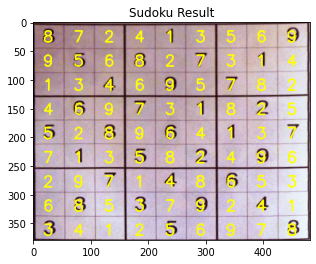

In [17]:
# loop over the cell locations and board
for (cellRow, boardRow) in zip(cellLocs, solution.board):
	# loop over individual cell in the row
	for (box, digit) in zip(cellRow, boardRow):
		# unpack the cell coordinates
		startX, startY, endX, endY = box

		# compute the coordinates of where the digit will be drawn
		# on the output puzzle image
		textX = int((endX - startX) * 0.33)
		textY = int((endY - startY) * -0.2)
		textX += startX
		textY += endY

		# draw the result digit on the Sudoku puzzle image
		cv2.putText(puzzleImage, str(digit), (textX, textY),
			cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)

# show the output image
plt_imshow("Sudoku Result", puzzleImage)